In [1]:
import gymnasium as gym
env = gym.make('Acrobot-v1')
obs = env.reset()

In [2]:
state = env.reset()
env.action_space.sample()
state

(array([ 0.99664533,  0.08184196,  0.9989383 , -0.04606756, -0.08770793,
         0.09467646], dtype=float32),
 {})

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
from collections import deque


class Policy(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = np.array(state)
        state = torch.from_numpy(state).float().unsqueeze(0).to("cpu")
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item()-1, model.log_prob(action)

In [4]:

class Value_function(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Value_function, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [7]:


max_trajectory = 1000
value_loss = nn.MSELoss()
tau = 0.0001


def reinforce_baseline(policy, optimizer, n_episodes, value_function, value_optimizer, gamma=0.99, print_every=5):
    scores = []
    target_value_function = Value_function(
        input_size=6, hidden_size=64, output_size=1)

    for episode in range(1, n_episodes):
        state = env.reset(seed=np.random.randint(1, 10))
        scores_deque = deque(maxlen=100)
        state = state[0]
        states = []
        states.append(state)
        saved_log_probs = []
        G = 0
        G_non_discounted = 0
        I = 1
        for t in range(max_trajectory):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            next_state, reward, done, truncated, info = env.step(action)
            states.append(next_state)
            value_optimizer.zero_grad()
            for target_param, param in zip(target_value_function.parameters(), value_function.parameters()):
                target_param.data.copy_(
                    tau * param.data + (1 - tau) * target_param.data)
            # if t % 150 == 0:
            #     target_value_function.load_state_dict(
            #         value_function.state_dict())
            loss = value_loss(value_function(torch.tensor(state, dtype=torch.float)), reward +
                              gamma*target_value_function(torch.tensor(next_state, dtype=torch.float)))

            loss.backward()
            value_optimizer.step()
            G += reward*I
            G_non_discounted += reward
            I = I*gamma
            if done or truncated:
                break
            state = next_state
        scores.append(G_non_discounted)
        scores_deque.append(G_non_discounted)
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob *
                               (G-value_function(torch.tensor(states, dtype=torch.float))))

        policy_loss = torch.cat(policy_loss).sum()
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(
                episode, np.mean(scores_deque)))

        if np.mean(scores_deque) >= -100 and episode > 800:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                episode, np.mean(scores_deque)))
            break

    return scores

In [8]:
n_seed = 5
final_scores_baseline = []
for i in range(n_seed):
    policy = Policy(input_size=6, hidden_size=64, output_size=3)
    optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)
    value_function = Value_function(
        input_size=6, hidden_size=64, output_size=1)
    value_optimizer = torch.optim.Adam(value_function.parameters(), lr=1e-3)
    scores = reinforce_baseline(policy, optimizer, 10000, value_function,
                                value_optimizer, print_every=100)
    final_scores_baseline.append(scores)

Episode 100	Average Score: -500.00
Episode 200	Average Score: -294.00
Episode 300	Average Score: -401.00
Episode 400	Average Score: -234.00
Episode 500	Average Score: -120.00
Episode 600	Average Score: -133.00
Episode 700	Average Score: -130.00
Episode 800	Average Score: -137.00
Environment solved in 815 episodes!	Average Score: -98.00
Episode 100	Average Score: -500.00
Episode 200	Average Score: -500.00
Episode 300	Average Score: -500.00
Episode 400	Average Score: -500.00
Episode 500	Average Score: -500.00
Episode 600	Average Score: -500.00
Episode 700	Average Score: -310.00
Episode 800	Average Score: -189.00
Episode 900	Average Score: -311.00
Episode 1000	Average Score: -237.00
Episode 1100	Average Score: -195.00
Episode 1200	Average Score: -203.00
Episode 1300	Average Score: -145.00
Episode 1400	Average Score: -122.00
Environment solved in 1421 episodes!	Average Score: -98.00
Episode 100	Average Score: -316.00
Episode 200	Average Score: -158.00
Episode 300	Average Score: -120.00
Epi

In [9]:
import pickle
with open('final_scores_baseline_acrobot', 'wb') as f:
    pickle.dump(final_scores_baseline, f)

In [165]:
import pickle
import numpy as np
with open('final_scores_baseline_acrobot', 'rb') as f:
    final_scores_baseline = pickle.load(f)

In [172]:
min_length_baseline = 10000
for row in final_scores_baseline:
    print(len(row))
    if min_length_baseline > len(row):
        min_length_baseline = len(row)

815
1421
804
803
802


Text(0.5, 1.0, 'REINFORCE Learning Curve')

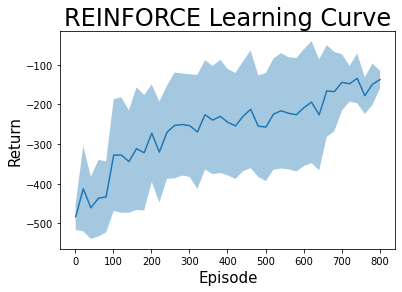

In [173]:
import matplotlib.pyplot as plt
clipped_data = [row[:min_length_baseline] for row in final_scores_baseline]
clipped_array = np.array(clipped_data)
means = np.mean(clipped_array, axis=0)[::20]
mins = means-np.std(clipped_array, axis=0)[::20]
maxs = means+np.std(clipped_array, axis=0)[::20]
ks = np.arange(1, min_length_baseline+1)[::20]
plt.fill_between(ks, mins, maxs, alpha=0.4)
plt.plot(ks, means)

plt.xlabel('Episode', fontsize=15)
plt.ylabel('Return', fontsize=15)

plt.title("REINFORCE Learning Curve", fontsize=24)

## Training for visualizing and Recording gif for with baseline 

In [182]:
policy_final = Policy(input_size=6, hidden_size=64, output_size=3)
optimizer = torch.optim.Adam(policy_final.parameters(), lr=1e-3)
value_function = Value_function(
    input_size=6, hidden_size=64, output_size=1)
value_optimizer = torch.optim.Adam(value_function.parameters(), lr=1e-3)
scores = reinforce_baseline(policy_final, optimizer, 10000, value_function,
                            value_optimizer, print_every=100)

Episode 100	Average Score: -94.00
Episode 200	Average Score: -182.00
Episode 300	Average Score: -98.00
Episode 400	Average Score: -115.00
Episode 500	Average Score: -161.00
Episode 600	Average Score: -127.00
Episode 700	Average Score: -102.00
Episode 800	Average Score: -82.00
Environment solved in 802 episodes!	Average Score: -93.00


In [18]:
# import matplotlib.pyplot as plt
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.plot(np.arange(1, len(scores)+1), scores)
# plt.ylabel('Score')
# plt.xlabel('Episode #')
# plt.show()

In [19]:
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import io
import base64

In [20]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def show_video_of_model(policy, env_name):
    env = gym.make(env_name, render_mode="human")
    vid = video_recorder.VideoRecorder(
        env, path="video/{}.mp4".format(env_name))
    state = env.reset(seed=0)
    state = state[0]
    done = False
    for t in range(1000):
        vid.capture_frame()
        action, _ = policy.act(state)
        next_state, reward, done, truncated, info = env.step(action)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [22]:
show_video_of_model(policy, 'Acrobot-v1')

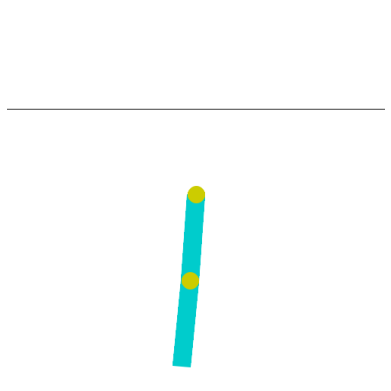

In [185]:
from matplotlib import animation

env = gym.make('Acrobot-v1', render_mode="rgb_array")
state, _ = env.reset()
frames = []
path = './'
filename = 'acrobot_baseline.gif'
for t in range(1000):
    frames.append(env.render())
    action, _ = policy_final.act(state)
    next_state, reward, done, truncated, info = env.step(action)
    state = next_state
    if done or truncated:
        break
env.close()
plt.figure(figsize=(frames[0].shape[1] / 72.0,
           frames[0].shape[0] / 72.0), dpi=72)
patch = plt.imshow(frames[0])
plt.axis('off')


def animate(i):
    patch.set_data(frames[i])


anim = animation.FuncAnimation(
    plt.gcf(), animate, frames=len(frames), interval=50)
anim.save(path + filename, writer='imagemagick', fps=60)

# Reinforce with No Baseline

In [144]:
env = gym.make('Acrobot-v1')
env.reset()

(array([ 0.99999946, -0.00101027,  0.99951845,  0.03102944, -0.08575138,
        -0.08281806], dtype=float32),
 {})

In [153]:
def reinforce_no_baseline(policy, optimizer, n_episodes, max_t=1000, gamma=0.99, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state, _ = env.reset(seed=np.random.randint(1, 10))
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, truncated, _ = env.step(action)
            rewards.append(reward)
            if done or truncated:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a, b in zip(discounts, rewards)])

        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(
                i_episode, np.mean(scores_deque)))

        if np.mean(scores_deque) > -100 and i_episode > 800:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                i_episode, np.mean(scores_deque)))
            break
    return scores

In [154]:
torch.manual_seed(0)


class Policy_no_baseline(nn.Module):
    def __init__(self, input_size=6, hidden_size=32, output_size=3):
        super(Policy_no_baseline, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to("cpu")
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item() - 1, m.log_prob(action)

In [155]:

n_seeds = 5
final_scores_no_baseline = []
for i in range(n_seeds):
    torch.manual_seed(0)
    policy2 = Policy_no_baseline(input_size=6, hidden_size=32, output_size=3)
    optimizer = torch.optim.Adam(policy2.parameters(), lr=0.001)

    scores = reinforce_no_baseline(
        policy2, optimizer, 10000, max_t=1000, print_every=100)
    final_scores_no_baseline.append(scores)

Episode 100	Average Score: -338.05
Episode 200	Average Score: -274.55
Episode 300	Average Score: -265.01
Episode 400	Average Score: -257.82
Episode 500	Average Score: -240.40
Episode 600	Average Score: -234.41
Episode 700	Average Score: -262.10
Episode 800	Average Score: -232.67
Episode 900	Average Score: -210.28
Episode 1000	Average Score: -221.31
Episode 1100	Average Score: -223.23
Episode 1200	Average Score: -215.02
Episode 1300	Average Score: -217.07
Episode 1400	Average Score: -208.56
Episode 1500	Average Score: -212.20
Episode 1600	Average Score: -218.27
Episode 1700	Average Score: -223.10
Episode 1800	Average Score: -190.24
Episode 1900	Average Score: -186.73
Episode 2000	Average Score: -181.20
Episode 2100	Average Score: -176.27
Episode 2200	Average Score: -160.61
Episode 2300	Average Score: -164.09
Episode 2400	Average Score: -151.08
Episode 2500	Average Score: -137.18
Episode 2600	Average Score: -137.55
Episode 2700	Average Score: -145.40
Episode 2800	Average Score: -131.94
E

In [188]:
import pickle
with open('final_scores_no_baseline_acrobot', 'wb') as f:
    pickle.dump(final_scores_no_baseline, f)

In [190]:
import pickle
import numpy as np
with open('final_scores_no_baseline_acrobot', 'rb') as f:
    final_scores_no_baseline = pickle.load(f)
final_scores_no_baseline

[[-402.0,
  -436.0,
  -292.0,
  -298.0,
  -363.0,
  -464.0,
  -399.0,
  -415.0,
  -383.0,
  -367.0,
  -301.0,
  -234.0,
  -416.0,
  -444.0,
  -281.0,
  -421.0,
  -340.0,
  -369.0,
  -236.0,
  -344.0,
  -277.0,
  -500.0,
  -366.0,
  -388.0,
  -303.0,
  -500.0,
  -379.0,
  -443.0,
  -500.0,
  -300.0,
  -495.0,
  -299.0,
  -424.0,
  -470.0,
  -395.0,
  -500.0,
  -174.0,
  -327.0,
  -453.0,
  -462.0,
  -405.0,
  -429.0,
  -199.0,
  -397.0,
  -228.0,
  -438.0,
  -360.0,
  -270.0,
  -225.0,
  -423.0,
  -304.0,
  -426.0,
  -257.0,
  -310.0,
  -161.0,
  -258.0,
  -296.0,
  -460.0,
  -419.0,
  -315.0,
  -359.0,
  -391.0,
  -405.0,
  -252.0,
  -348.0,
  -423.0,
  -207.0,
  -352.0,
  -244.0,
  -329.0,
  -218.0,
  -442.0,
  -252.0,
  -249.0,
  -244.0,
  -246.0,
  -320.0,
  -270.0,
  -305.0,
  -351.0,
  -309.0,
  -227.0,
  -314.0,
  -223.0,
  -344.0,
  -277.0,
  -253.0,
  -261.0,
  -284.0,
  -278.0,
  -338.0,
  -253.0,
  -193.0,
  -500.0,
  -200.0,
  -262.0,
  -301.0,
  -321.0,
  -286.0,
  -434.0,


In [162]:
min_length_no_baseline = 10000
for row in final_scores_no_baseline:
    print(len(row))
    if min_length_no_baseline > len(row):
        min_length_no_baseline = len(row)
min_length_no_baseline

10000
7341
7485
7056
5920


5920

Text(0.5, 1.0, 'REINFORCE Learning Curve')

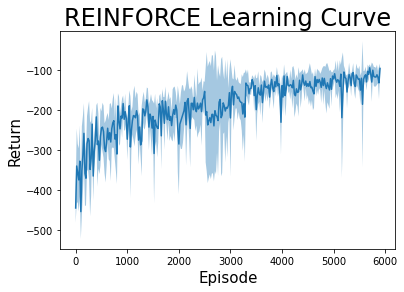

In [164]:
import matplotlib.pyplot as plt
clipped_data = [row[:min_length_no_baseline]
                for row in final_scores_no_baseline]
clipped_array = np.array(clipped_data)
means = np.mean(clipped_array, axis=0)[::20]
mins = means-np.std(clipped_array, axis=0)[::20]
maxs = means+np.std(clipped_array, axis=0)[::20]
ks = np.arange(1, min_length_no_baseline+1)[::20]
plt.fill_between(ks, mins, maxs, alpha=0.4)
plt.plot(ks, means)

plt.xlabel('Episode', fontsize=15)
plt.ylabel('Return', fontsize=15)

plt.title("REINFORCE Learning Curve", fontsize=24)

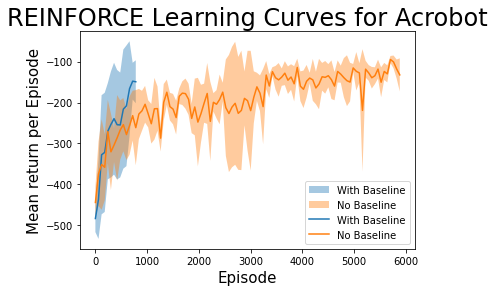

In [187]:
import matplotlib.pyplot as plt
import numpy as np


clipped_data_baseline = [row[:min_length_baseline]
                         for row in final_scores_baseline]
clipped_array_baseline = np.array(clipped_data_baseline)

clipped_data_no_baseline = [row[:min_length_no_baseline]
                            for row in final_scores_no_baseline]
clipped_array_no_baseline = np.array(clipped_data_no_baseline)

means_baseline = np.mean(clipped_array_baseline, axis=0)[::60]
mins_baseline = means_baseline-np.std(clipped_array_baseline, axis=0)[::60]
maxs_baseline = means_baseline+np.std(clipped_array_baseline, axis=0)[::60]

means_no_baseline = np.mean(clipped_array_no_baseline, axis=0)[::60]
mins_no_baseline = means_no_baseline - \
    np.std(clipped_array_no_baseline, axis=0)[::60]
maxs_no_baseline = means_no_baseline + \
    np.std(clipped_array_no_baseline, axis=0)[::60]

ks_baseline = np.arange(1, min_length_baseline+1)[::60]
ks_no_baseline = np.arange(1, min_length_no_baseline+1)[::60]

plt.fill_between(ks_baseline, mins_baseline, maxs_baseline,
                 alpha=0.4, label='With Baseline')
plt.fill_between(ks_no_baseline, mins_no_baseline,
                 maxs_no_baseline, alpha=0.4, label='No Baseline')


plt.plot(ks_baseline, means_baseline, label='With Baseline')
plt.plot(ks_no_baseline, means_no_baseline, label='No Baseline')


plt.xlabel('Episode', fontsize=15)
plt.ylabel('Mean return per Episode', fontsize=15)
plt.title("REINFORCE Learning Curves for Acrobot", fontsize=24)

plt.legend()

plt.show()

# Training For one iteration and visualizing for without baseline

In [177]:
torch.manual_seed(0)
policy_no_baseline = Policy_no_baseline(
    input_size=6, hidden_size=32, output_size=3)
optimizer = torch.optim.Adam(policy_no_baseline.parameters(), lr=0.001)
scores = reinforce_no_baseline(
    policy_no_baseline, optimizer, 10000, max_t=1000, print_every=100)

Episode 100	Average Score: -363.55
Episode 200	Average Score: -355.02
Episode 300	Average Score: -390.58
Episode 400	Average Score: -345.56
Episode 500	Average Score: -276.89
Episode 600	Average Score: -277.70
Episode 700	Average Score: -226.21
Episode 800	Average Score: -218.27
Episode 900	Average Score: -222.35
Episode 1000	Average Score: -196.39
Episode 1100	Average Score: -194.49
Episode 1200	Average Score: -199.64
Episode 1300	Average Score: -223.84
Episode 1400	Average Score: -226.92
Episode 1500	Average Score: -226.88
Episode 1600	Average Score: -291.19
Episode 1700	Average Score: -302.53
Episode 1800	Average Score: -236.20
Episode 1900	Average Score: -210.22
Episode 2000	Average Score: -223.35
Episode 2100	Average Score: -212.97
Episode 2200	Average Score: -231.82
Episode 2300	Average Score: -209.65
Episode 2400	Average Score: -174.84
Episode 2500	Average Score: -173.22
Episode 2600	Average Score: -157.22
Episode 2700	Average Score: -152.72
Episode 2800	Average Score: -148.94
E

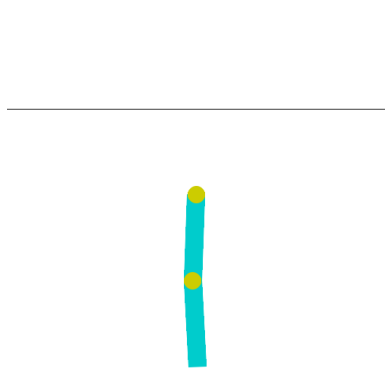

In [179]:
from matplotlib import animation
import matplotlib.pyplot as plt
env = gym.make('Acrobot-v1', render_mode="rgb_array")
state, _ = env.reset()
frames = []
path = './'
filename = 'acrobot_no_baseline.gif'
for t in range(1000):
    frames.append(env.render())
    action, _ = policy_no_baseline.act(state)
    next_state, reward, done, truncated, info = env.step(action)
    state = next_state
    if done or truncated:
        break
env.close()
plt.figure(figsize=(frames[0].shape[1] / 72.0,
           frames[0].shape[0] / 72.0), dpi=72)
patch = plt.imshow(frames[0])
plt.axis('off')


def animate(i):
    patch.set_data(frames[i])


anim = animation.FuncAnimation(
    plt.gcf(), animate, frames=len(frames), interval=50)
anim.save(path + filename, writer='imagemagick', fps=60)